In [352]:
using Revise
using EAMC
using Plots
using LinearAlgebra
using SparseArrays
using StatsBase

# utility functions
cg = cgrad(:matter, scale=:exp)
#cg.colors[1] = colorant"white"
#cg.values[2]=eps()

hm(x; kwargs...) = begin
    h = heatmap(x|>collect, yflip=true, color = cg; kwargs...)
    push!(myplots, h)
    h
end


hm (generic function with 1 method)

In [377]:
# experiment setup

beta = 1 # inverse temp / noise
period = 1 # forcing period
force = 10 # forcing amplitude
phi = 1 # time scaling
tmax = period * 4 # time

nx = 5
nt = round(Int, tmax / period * 4)

x0 = 2

ts = range(0, tmax, length=nt+1)
xmax = 1.5
xs = range(-xmax,xmax, length=nx)


process = EAMC.OverdampedLangevin(
    V = (x,t) -> beta * (x^2-1)^2 + force * sin(t / period * 2 * pi) * x,
    phi = phi,
    grid = xs)

qs = [EAMC.generatormatrix(process, t) for t in ts];

myplots = [];

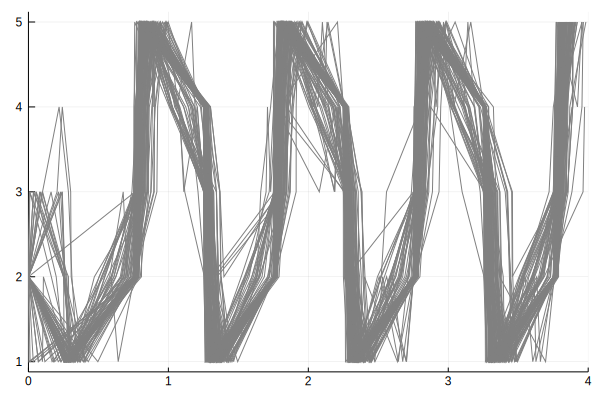

In [378]:
p=plot(legend=false)
for i=1:100
plot!(EAMC.gillespie(qs, ts, x0, tmax), xlims=(0, tmax), color=:grey)
end; p

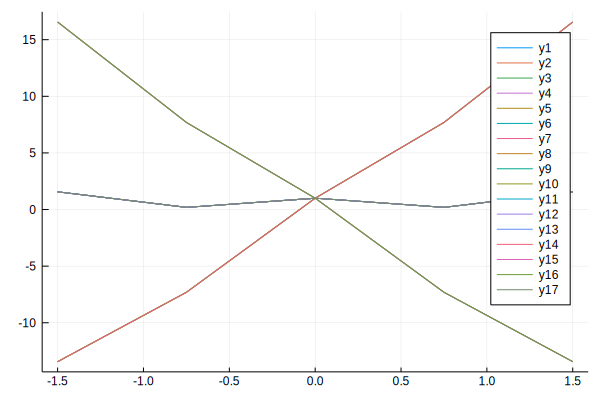

In [322]:
plot(xs, [x->process.V(x,t) for t in ts])

In [245]:
g = galerkin(qs, ts);

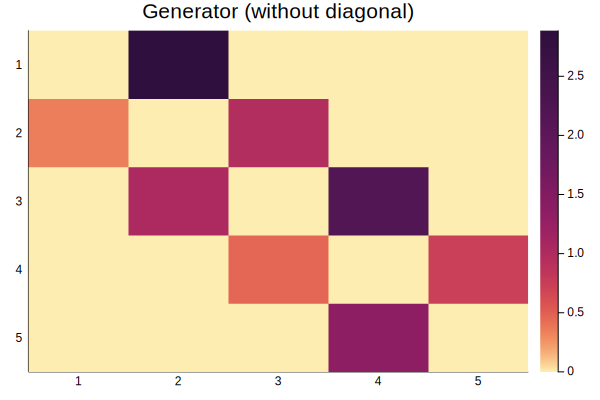

In [246]:
let q = qs[4]
    hm(q-Diagonal(q), title="Generator (without diagonal)")
end

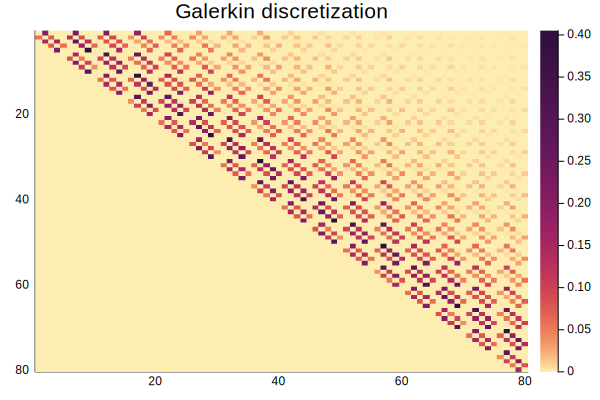

In [247]:
hm(g, color=cg, title="Galerkin discretization")

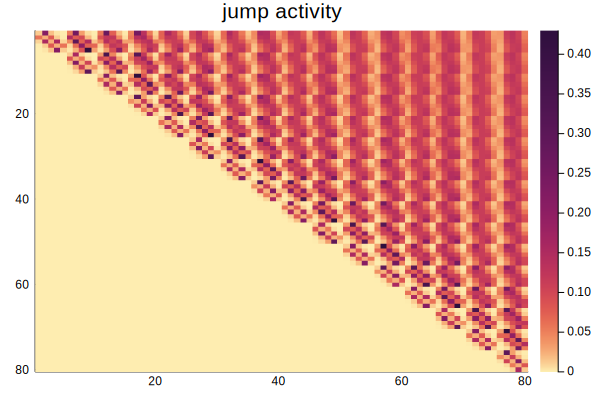

In [248]:
E = EAMC.jumpactivity(g)
hm(E, title="jump activity")

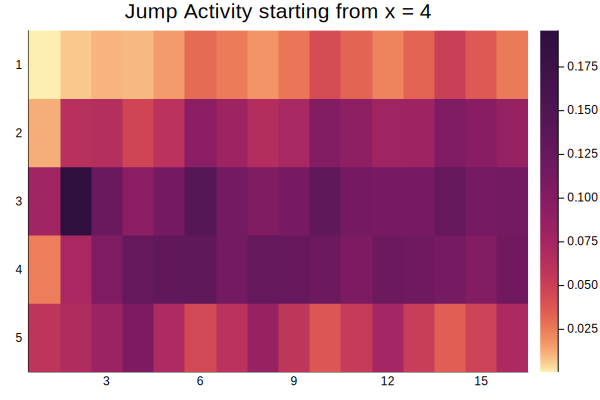

In [249]:
f0=zeros(nx)
x0 = 4
f0[x0] = 1
act = EAMC.project_jumpactivity(E, f0)
hm(act, title="Jump Activity starting from x = $x0")

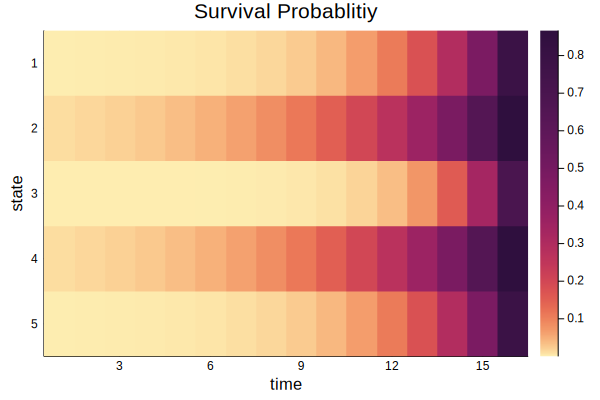

In [250]:
#survival from inside each timecell to T
qout = [collect(-diag(q)) for q in qs]
q = qout[1]
i = 4
S=zeros(nx, nt)
for i=1:nt
    S[:,i] .= 1 ./ q .*(exp.(-q*(ts[end] - ts[i+1])) - exp.(-q*(ts[end] - ts[i]))) / (ts[i+1]-ts[i])
end
hm(S, title="Survival Probablitiy", xlabel="time", ylabel="state")

In [251]:
Pf = EAMC.perronfrobenius(g, qs, ts)

5×5 Adjoint{Float64,Array{Float64,2}}:
 0.114406   0.109376   0.0923626  0.072828  0.066561
 0.404456   0.388791   0.345934   0.294067  0.277121
 0.157033   0.155995   0.152953   0.149317  0.148086
 0.281094   0.295606   0.335932   0.383556  0.397976
 0.0792922  0.0858314  0.104497   0.126665  0.133634

In [252]:
Pf_exp = exp(qs[1]|>collect)'

5×5 Adjoint{Float64,Array{Float64,2}}:
 0.245213    0.142604   0.0669267  0.0172218  0.00766856
 0.56181     0.564164   0.340904   0.124143   0.0678481 
 0.11746     0.151868   0.184338   0.151868   0.11746   
 0.0678481   0.124143   0.340904   0.564164   0.56181   
 0.00766856  0.0172218  0.0669267  0.142604   0.245213  

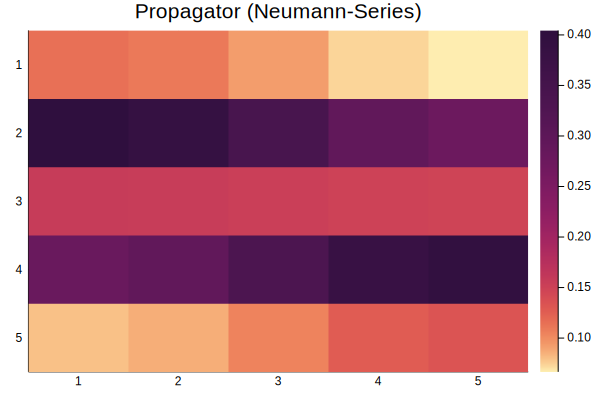

In [253]:
hm(Pf, title="Propagator (Neumann-Series)")

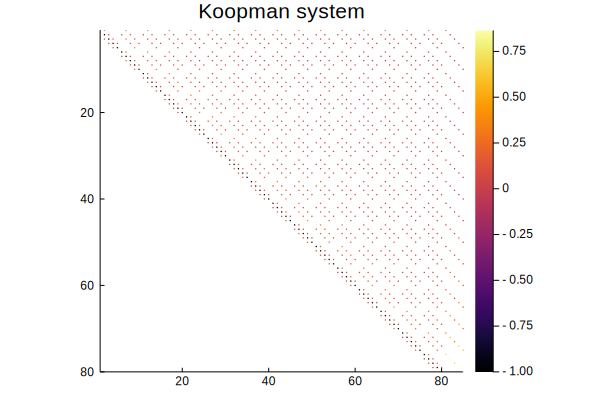

In [254]:
A = EAMC.koopman_system(g, nx)
spy(A, title="Koopman system")

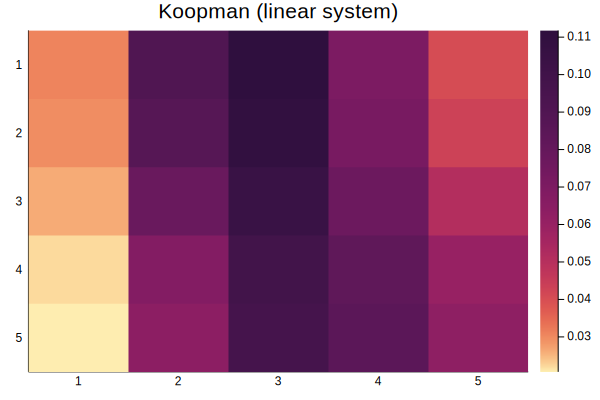

In [255]:
K = EAMC.koopman(g, nx)
hm(K, title="Koopman (linear system)")

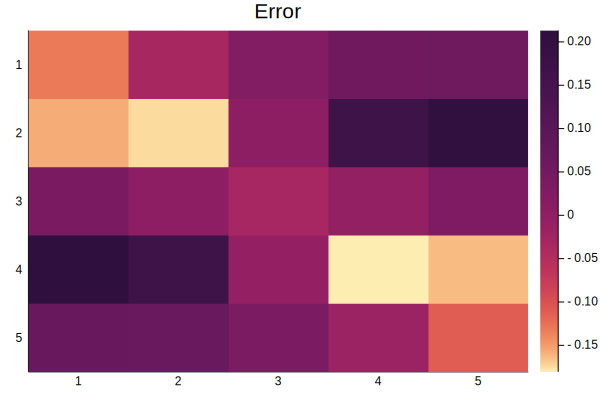

In [256]:
hm(Pf - Pf_exp, title="Error")

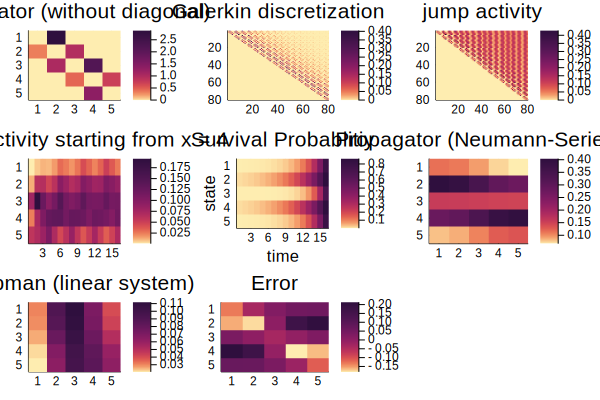

In [257]:
plot(myplots...)